# Evolution of urban patterns: urban morphology as an open reproducible data science

## Summary statistics

This is the second notebook in a sequence of three. The notebook summarise morphometric data obtained in the previous notebook on the basis of historical periods.

It requires `data/case_studies.csv` input with origins of case studies and data generated by the first notebook.

Date: February 5, 2021

In [1]:
import pandas as pd
import seaborn as sns
from shapely.geometry import Point
import geopandas as gpd
import matplotlib.pyplot as plt
import glob
import pathlib
from palettable.wesanderson import Moonrise5_6

Matplotlib created a temporary config/cache directory at /tmp/matplotlib-aa5zhdq4 because the default path (/home/jovyan/.config/matplotlib) is not a writable directory; it is highly recommended to set the MPLCONFIGDIR environment variable to a writable directory, in particular to speed up the import of Matplotlib and to better support multiprocessing.


In [2]:
sns.set()

In [3]:
cases = pd.read_csv("data/case_studies.csv")
cases

,case,period,origin
0,Athens,pre-industrial,"(23.729297894645065, 37.977742321097296)"
1,Brugge,pre-industrial,"(3.222135599564842, 51.20663413385126)"
2,Havana,pre-industrial,"(-82.35387869733259, 23.137058811383366)"
3,Kyoto,pre-industrial,"(135.77513789847612, 35.00441991880096)"
4,Nuremberg,pre-industrial,"(11.080741895925831, 49.4558122318182)"
5,Pavia,pre-industrial,"(9.155202505665285, 45.18542787308676)"
6,Recife,pre-industrial,"(-34.87950134898907, -8.066819977715335)"
7,Barcelona,industrial,"(2.1599658311051333, 41.39207228345335)"
8,Brisbane,industrial,"(153.00890689998246, -27.483072513877765)"
9,Buenos Aires,industrial,"(-58.37436109734774, -34.618526518125655)"


In [4]:
cases = cases.set_index("case")

In [5]:
files = glob.glob("data/*gpkg")

In [6]:
data = pd.DataFrame()

In [7]:
for f in files:
    tessellation = gpd.read_file(f, layer="tessellation")
    case = pathlib.Path(f).stem
    coords = cases.origin.loc[case]
    buffer = gpd.GeoSeries([Point(tuple(map(float, coords[1:-1].split(', '))))], crs=4326).to_crs(tessellation.crs).buffer(400)
    tessellation['period'] = cases.period.loc[case]
    tessellation['case'] = case
    casegdf = tessellation[tessellation.centroid.within(buffer.iloc[0])]
    data = data.append(casegdf.drop(columns=["uID", "nID", "mm_len", "node_start", "node_end", "nodeID", "geometry"]))

/opt/conda/lib/python3.8/site-packages/geopandas/geodataframe.py:422: RuntimeWarning: Sequential read of iterator was interrupted. Resetting iterator. This can negatively impact the performance.
  for feature in features_lst:


In [8]:
data['period'] = pd.Categorical(data['period'], categories=['pre-industrial', 'industrial', 'garden city', 'modernist', 'neo-traditional', 'informal'], ordered=True)

In [9]:
data = data.sort_values('period').reset_index(drop=True)

In [10]:
sns.set_context("paper")
sns.set_style("whitegrid")
sns.set_palette(Moonrise5_6.hex_colors)

In [11]:
labels = {
    "cell_area": "Area of a tessellation cell [m]",
    "car": "Covered area ratio",
    "blg_area": "Area of a building footprint [m]",
    "wall": "Length of a perimeter wall [m]",
    "adjacency": "Building adjacency",
    "neighbour_distance": "Mean neighbor distance between buildings [m]",
    "length": "Length of a street segment [m]",
    "linearity": "Linearity of a street segment",
    "width": "Width of a street profile [m]",
    "width_deviation": "Width deviation of a street profile [m]",
    "openness": "Openness of a street profile",
    "meshedness": "Meshedness of a street network",
}

In [12]:
for ch in data.columns.drop(['case', 'period']):
    plt.figure(figsize=(12, 8))
    boxen = sns.boxplot(x="case", y=ch, hue='period', dodge=False, data=data, showfliers=False)
    boxen.set_xticklabels(boxen.get_xticklabels(), rotation=90)
    boxen.set_ylabel(labels[ch])
    boxen.set_xlabel("Case study")
    sns.despine()
    plt.legend(loc="lower left", borderaxespad=0., ncol=6, frameon=False)
    plt.savefig(f"figures/{ch}_all_normal.png", bbox_inches="tight")
    plt.close("all")
    
    plt.figure(figsize=(12, 8))
    boxen = sns.boxplot(x="case", y=ch, hue='period', dodge=False, data=data, showfliers=False)
    boxen.set_xticklabels(boxen.get_xticklabels(), rotation=90)
    boxen.set_ylabel(labels[ch])
    boxen.set_xlabel("Case study")
    boxen.set_yscale("log")
    sns.despine()
    plt.legend(loc="lower left", borderaxespad=0., ncol=6, frameon=False)
    plt.savefig(f"figures/{ch}_all_log.png", bbox_inches="tight")
    plt.close("all")

In [13]:
for ch in data.columns.drop(['case', 'period']):
    plt.figure(figsize=(12, 8))
    box = sns.boxplot(x="period", y=ch,dodge=False, data=data, showfliers=False)
    box.set_ylabel(labels[ch])
    box.set_xlabel("Historical period")
    sns.despine()
    plt.savefig(f"figures/{ch}_grouped_normal.png", bbox_inches="tight")
    plt.close("all")
    
    plt.figure(figsize=(12, 8))
    box = sns.boxplot(x="period", y=ch,dodge=False, data=data, showfliers=False)
    box.set_ylabel(labels[ch])
    box.set_xlabel("Historical period")
    box.set_yscale("log")
    sns.despine()
    plt.savefig(f"figures/{ch}_grouped_log.png", bbox_inches="tight")
    plt.close("all")

In [76]:
grouped = data.drop(columns='case').groupby('period').mean()
grouped = grouped.rename(columns=labels)

In [77]:
grouped.T.round(3)

period,pre-industrial,industrial,garden city,modernist,neo-traditional,informal
Area of a tessellation cell [m],324.619,331.812,799.880,4036.855,792.000,154.852
Covered area ratio,0.591,0.512,0.241,0.174,0.273,0.498
Area of a building footprint [m],171.205,162.806,166.111,633.097,177.754,66.952
Length of a perimeter wall [m],319.051,364.035,110.165,192.139,95.881,74.455
Building adjacency,0.367,0.341,0.793,0.803,0.810,0.888
Mean neighbor distance between buildings [m],4.764,7.624,15.629,35.467,15.865,3.983
Lenght of a street segment [m],119.746,165.068,165.845,220.116,142.704,159.069
Linearity of a street segment,0.961,0.996,0.919,0.911,0.937,0.933
Width of a street profile [m],12.082,17.104,29.075,32.732,26.520,13.629
Width deviation of a street profile [m],3.198,2.407,3.501,3.184,3.127,4.763


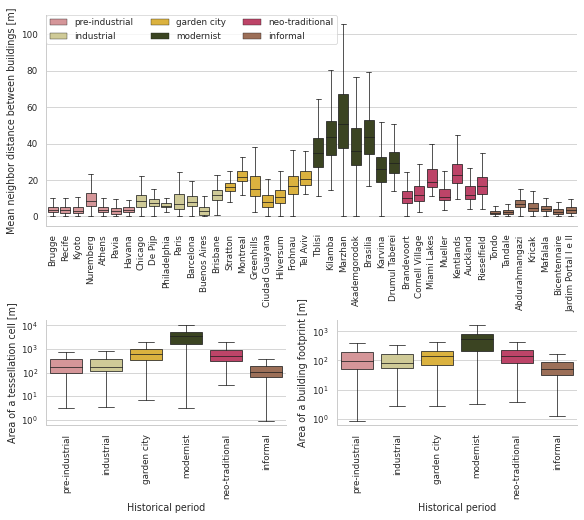

In [67]:
fig = plt.figure(figsize=(8, 7), constrained_layout=True)
gs = fig.add_gridspec(6, 2)
top = fig.add_subplot(gs[0:4, :])
left = fig.add_subplot(gs[4:, 0])
right = fig.add_subplot(gs[4:, 1])

sns.boxplot(x="case", y='neighbour_distance', hue='period', dodge=False, data=data, showfliers=False, ax=top, linewidth=.75)
top.set_xticklabels(top.get_xticklabels(), rotation=90)
top.set_ylabel(labels['neighbour_distance'])
top.set_xlabel("")

sns.boxplot(x="period", y='cell_area',dodge=False, data=data, showfliers=False, ax=left, linewidth=.75)
left.set_ylabel(labels['cell_area'])
left.set_xlabel("Historical period")
left.set_xticklabels(left.get_xticklabels(), rotation=90)
left.set_yscale("log")

sns.boxplot(x="period", y='blg_area',dodge=False, data=data, showfliers=False, ax=right, linewidth=.75)
right.set_ylabel(labels['blg_area'])
right.set_xlabel("Historical period")
right.set_xticklabels(right.get_xticklabels(), rotation=90)
right.set_yscale("log")
sns.despine()

top.legend(loc="upper left", borderaxespad=0., ncol=3, frameon=True)
plt.savefig(f"figures/results_1.png", bbox_inches="tight", dpi=300)

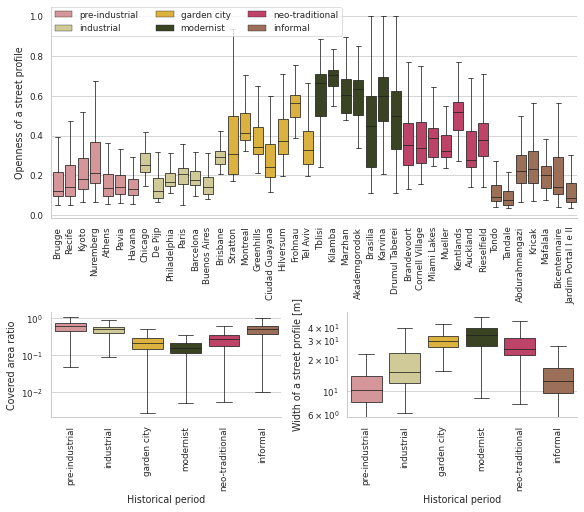

In [66]:
fig = plt.figure(figsize=(8, 7), constrained_layout=True)
gs = fig.add_gridspec(6, 2)
top = fig.add_subplot(gs[0:4, :])
left = fig.add_subplot(gs[4:, 0])
right = fig.add_subplot(gs[4:, 1])

sns.boxplot(x="case", y='openness', hue='period', dodge=False, data=data, showfliers=False, ax=top, linewidth=.75)
top.set_xticklabels(top.get_xticklabels(), rotation=90)
top.set_ylabel(labels['openness'])
top.set_xlabel("")

sns.boxplot(x="period", y='car',dodge=False, data=data, showfliers=False, ax=left, linewidth=.75)
left.set_ylabel(labels['car'])
left.set_xlabel("Historical period")
left.set_xticklabels(left.get_xticklabels(), rotation=90)
left.set_yscale("log")

sns.boxplot(x="period", y='width',dodge=False, data=data, showfliers=False, ax=right, linewidth=.75)
right.set_ylabel(labels['width'])
right.set_xlabel("Historical period")
right.set_xticklabels(right.get_xticklabels(), rotation=90)
right.set_yscale("log")
sns.despine()

top.legend(loc="upper left", borderaxespad=0., ncol=3, frameon=True)
plt.savefig(f"figures/results_2.png", bbox_inches="tight", dpi=300)

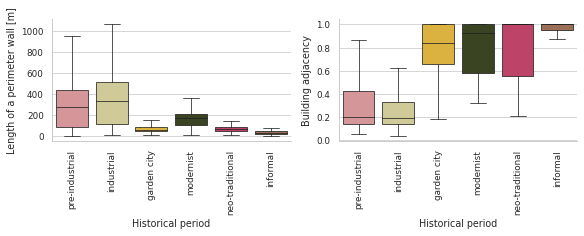

In [72]:
fig = plt.figure(figsize=(8, 3), constrained_layout=True)
gs = fig.add_gridspec(1, 2)
left = fig.add_subplot(gs[0, 0])
right = fig.add_subplot(gs[0, 1])

sns.boxplot(x="period", y='wall',dodge=False, data=data, showfliers=False, ax=left, linewidth=.75)
left.set_ylabel(labels['wall'])
left.set_xlabel("Historical period")
left.set_xticklabels(left.get_xticklabels(), rotation=90)

sns.boxplot(x="period", y='adjacency',dodge=False, data=data, showfliers=False, ax=right, linewidth=.75)
right.set_ylabel(labels['adjacency'])
right.set_xlabel("Historical period")
right.set_xticklabels(right.get_xticklabels(), rotation=90)
sns.despine()

plt.savefig(f"figures/results_3.png", bbox_inches="tight", dpi=300)

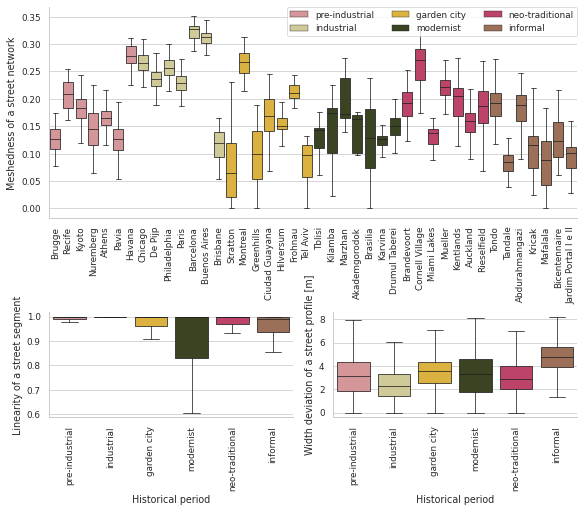

In [75]:
fig = plt.figure(figsize=(8, 7), constrained_layout=True)
gs = fig.add_gridspec(6, 2)
top = fig.add_subplot(gs[0:4, :])
left = fig.add_subplot(gs[4:, 0])
right = fig.add_subplot(gs[4:, 1])

sns.boxplot(x="case", y='meshedness', hue='period', dodge=False, data=data, showfliers=False, ax=top, linewidth=.75)
top.set_xticklabels(top.get_xticklabels(), rotation=90)
top.set_ylabel(labels['meshedness'])
top.set_xlabel("")

sns.boxplot(x="period", y='linearity',dodge=False, data=data, showfliers=False, ax=left, linewidth=.75)
left.set_ylabel(labels['linearity'])
left.set_xlabel("Historical period")
left.set_xticklabels(left.get_xticklabels(), rotation=90)

sns.boxplot(x="period", y='width_deviation',dodge=False, data=data, showfliers=False, ax=right, linewidth=.75)
right.set_ylabel(labels['width_deviation'])
right.set_xlabel("Historical period")
right.set_xticklabels(right.get_xticklabels(), rotation=90)
sns.despine()

top.legend(loc="upper right", borderaxespad=0., ncol=3, frameon=True)
plt.savefig(f"figures/results_4.png", bbox_inches="tight", dpi=300)